In [289]:
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import time
from pylab import *
from sklearn import datasets, linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
from pandas_datareader import data
import yfinance as yf  # yfinance manuels: https://github.com/ranaroussi/yfinance

In [290]:
today=date.today()
checkList=[]
def welcome():
    wel_txt='Dear user, welcome to Auto Stock Checker Bot.\
          First of all I\'d like to have your name.'
    name=input(wel_txt)
    if len(name)==0:
        print('Welcome, dear User.')
    else:
        print('Welcome to ASCB', name,'.')

In [291]:
def getTicker():
    # Let user enter target market, return price dataframe
    wel_txt='Please let me know what stock information you want to know.'
    symbol=input(wel_txt)
    symbolSignal=enterSymbol(symbol)
    print('This is the', symbol,'\'s price.')
    print(symbolSignal.SymbolCheck())
    if symbolSignal.SymbolCheck() == 1:
        symbolDf=data.get_data_yahoo(symbol,'2017-01-01', today)
        # In eachtime user successed load a symbol, it will be add into list
        checkList.append(symbol)
        print(symbolDf.tail(1))
        return symbolDf
    else:
        print('The symbol you entered is not list in Bot. Sorry.')

In [292]:
class enterSymbol():
    '''
    enterSymbol is a easy checker to
    make sure the symbol that user's entered
    is valid to get ticker from Yahoo.
    If symbolValid is 1, then will return positive infor.
    '''
    def __init__(self, symbol):
        self.symbol=str(symbol)
        
    def SymbolChecker(self):
        try:
            data.get_data_yahoo(self.symbol,'2020-12-31',today).info
        except:
            return False
        else:
            return True
    
    def SymbolCheck(self):
        start_txt='I am checking'+self.symbol
        symbolValid=0
        if len(self.symbol) != 0:
            symbolValid=1
            if SymbolChecker(self.symbol) == True:
                return symbolValid
            else:
                symbolValid=0
                print('Symbol not found')
        else:
            symbolValid=0
            print('I cannot found information.')

In [293]:
class priceData():
    '''Once we get the data from yahoo, we can have
    different method to analyze the stock
    '''
    def __init__(self, dataframe):
        self.dataframe=dataframe
        
    def getStatisticalInfo(self):
        # To get statistic data for everyday close price
        return self.dataframe['Close'].describe()
    
    def change(self):
        closeCol=self.dataframe['Close']
        # Buy Price
        buyPrice=closeCol[0]
        # Present Price
        curPrice=closeCol[closeCol.size-1]
        # cummulate gross
        priceChange=(curPrice-buyPrice)/buyPrice
        if (priceChange>0):
            print('Stock grossed:', priceChange*100,'%')
        elif (priceChange==0):
            print('Stock no PNL')
        else:
            print('Stock lost:', priceChange*100,'%')
        return priceChange
    
    def priceTrend(self):
        # Price Trend
        '''X-axis is date index, y is the close price
        in default, plot will return line graph'''
        # plot use_index=True will automatic use Datetime index as X-axis
        self.dataframe.plot(y="Close",use_index=True,color='b',label='price')
        plt.xlabel('Date')
        plt.ylabel('Price(USD)')
        plt.title('Alibaba Price')
        plt.grid(True)  # Turn on grid
        plt.legend(loc='best') # Turn on legend
        plt.show()
        
    def priceVPVR(self):
        # Volume Profile Visible Range
        '''X-axis is volume of traded
        y-axis is Close price
        the graph use bar'''
        self.datafram.plot(x='Volume',y='Close',kind='scatter')
        plt.xlabel('Volume')
        plt.ylabel('Price(USD)')
        plt.title("VPVR")
        plt.grid(True)
        plt.show()
    
    def correlation(self):
        return self.dataframe.corr()

In [294]:
# Use all symbols to create a multi-graph
def createGraph(checklist):
    stock1=checklist[0]
    stock1Df=data.get_data_yahoo(stock1,'2017-01-01', today)
    ax1=stock1Df.plot(y="Close", use_index=True, label=stock1)
    for symbol in checklist[1::]:
        data.get_data_yahoo(symbol,'2017-01-01', 
                            today).plot(ax=ax1,y="Close", 
                                        use_index=True, label=symbol)
    plt.xlabel('Datetime')
    plt.ylabel('Price(USD)')
    plt.title("Comparation of Companies")
    plt.grid(True)
    plt.show()
    
def mergeData(checklist):
    # merge close price data
    closeDf=pd.DataFrame()
    for symbol in checklist:
        symbolDf=data.get_data_yahoo(symbol,'2017-01-01', today)
        closeDf=pd.concat([closeDf,symbolDf["Close"]], axis=1)
    # Rename header
    closeDf.columns=checklist
    # Check data
    print(closeDf.tail())
    return closeDf

def correlation(checklist):
    return mergeData(checklist).corr()

In [435]:
class portfolioManage():
    def __init__(self, checklist):
        self.checklist=checklist

    def dailyChange(self):
        portDf=mergeData(self.checklist)
        portDf=portDf.dropna()
        port_pct_change = portDf.pct_change()
        port_pct_change.fillna(0, inplace=True)
        #self.portDf=portDf
        self.port_pct_change=port_pct_change
        return port_pct_change

    def expectedReturn(self):
        expreturn = np.array(self.port_pct_change.mean())
        self.expreturn=expreturn
        return expreturn

    def varianceCovariance(self):
        # var_covar matix = 
        # transpose(stock price value changes - expect return) * (stock price value changes - expect return)
        var_covar = np.dot((self.port_pct_change.values-self.expreturn).T,
                           (self.port_pct_change.values-self.expreturn))
        return var_covar
    
    def marketCap(self):
        # Using marketCap to assume the weight of portfolio
        marketcapita=pd.DataFrame(columns=['marketCap'])
        for sym in self.checklist:
            capita=yf.Ticker(sym).info['marketCap']
            marketcapita.loc[sym,'marketCap']=capita
        self.marketcapita=marketcapita
        return marketcapita
    
    def portfolioWeight(self):
        marketWeight=pd.DataFrame(columns=['weight'])
        for sym in self.checklist:
            marketWeight.loc[sym,'weight']=self.marketcapita.loc[sym,'marketCap']/self.marketcapita['marketCap'].sum()
        return marketWeight

In [451]:
a=portfolioManage(checkList)
StockReturns=a.dailyChange().copy()

                           NIO        JKS         JD
2021-11-16 00:00:00  40.669998  63.880001  85.730003
2021-11-17 00:00:00  39.669998  63.090000  83.150002
2021-11-18 00:00:00  38.410000  58.049999  88.099998
2021-11-19 00:00:00  38.660000  63.689999  91.550003
2021-11-22 00:00:00  41.490002  60.299999  87.709999


In [437]:
a.expectedReturn()

array([0.00408923, 0.00343627, 0.00191954])

In [438]:
a.varianceCovariance()

array([[3.35381201, 0.74488952, 0.41868912],
       [0.74488952, 2.34402114, 0.46638523],
       [0.41868912, 0.46638523, 0.69637282]])

In [453]:
a.marketCap()

,marketCap
NIO,65992753152
JKS,2875532032
JD,136139956224


In [454]:
a.portfolioWeight()

,weight
NIO,0.321903
JKS,0.014026
JD,0.664071


In [455]:
portfolio_weights=np.array(a.portfolioWeight()).T
portfolio_weights

array([[0.32190292789577957, 0.014026421631885617, 0.6640706504723348]],
      dtype=object)

In [456]:
stock_return = a.dailyChange().copy()
WeightedReturns = stock_return.mul(portfolio_weights, axis=1)
WeightedReturns

                           NIO        JKS         JD
2021-11-16 00:00:00  40.669998  63.880001  85.730003
2021-11-17 00:00:00  39.669998  63.090000  83.150002
2021-11-18 00:00:00  38.410000  58.049999  88.099998
2021-11-19 00:00:00  38.660000  63.689999  91.550003
2021-11-22 00:00:00  41.490002  60.299999  87.709999


,NIO,JKS,JD
2018-09-12,0.0,0.0,0.0
2018-09-13,0.243866,-0.000503,0.003124
2018-09-14,-0.047175,0.000045,-0.015549
2018-09-17,-0.045522,-0.000305,-0.033804
2018-09-18,-0.031054,0.000346,0.000516
...,...,...,...
2021-11-16,0.000793,0.001068,0.008711
2021-11-17,-0.007915,-0.000173,-0.019985
2021-11-18,-0.010224,-0.001121,0.039533
2021-11-19,0.002095,0.001363,0.026005


In [457]:
StockReturns['Portfolio'] = WeightedReturns.sum(axis=1)

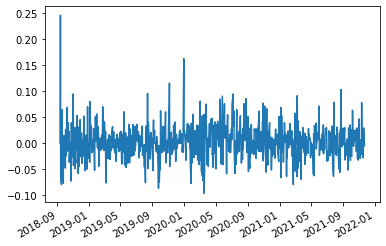

In [458]:
# Use marketCap Weight, the return of the portfolio in each day.
StockReturns.Portfolio.plot()
plt.show()

In [539]:
# 计算累积的组合收益，并绘图
# 累积收益曲线绘制函数
def cumulative_returns_plot(checklist):
    for name in checkList:
        CumulativeReturns = ((1+StockReturns[name]).cumprod()-1)
        CumulativeReturns.plot(label=name)
    plt.legend()
    plt.show()

                           NIO        JKS         JD
2021-11-16 00:00:00  40.669998  63.880001  85.730003
2021-11-17 00:00:00  39.669998  63.090000  83.150002
2021-11-18 00:00:00  38.410000  58.049999  88.099998
2021-11-19 00:00:00  38.660000  63.689999  91.550003
2021-11-22 00:00:00  41.490002  60.299999  87.709999


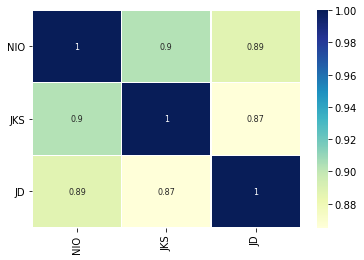

In [460]:
# 创建热图
sns.heatmap(correlation(checkList),
            annot=True,
            cmap="YlGnBu", 
            linewidths=0.3,
            annot_kws={"size": 8})

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

In [463]:
cov_mat = stock_return.cov()
cov_mat_annual = cov_mat * 252
print(cov_mat_annual)

          NIO       JKS        JD
NIO  1.051382  0.231958  0.130120
JKS  0.231958  0.734784  0.146776
JD   0.130120  0.146776  0.218597


In [497]:
portfolio_weights

array([[0.32190292789577957],
       [0.014026421631885617],
       [0.6640706504723348]], dtype=object)

In [501]:
# In portfolio volatility, we need to use 3X1 array as weight to caltulate.
portfolio_var = np.dot(portfolio_weights.T,np.dot(cov_mat_annual, portfolio_weights))
portfolio_volatility = np.sqrt(float(portfolio_volatility))

0.5157021840861276

In [532]:
number = 1000
# 设置空的numpy数组，用于存储每次模拟得到的权重、收益率和标准差
random_p = np.empty((number, 5))
# 设置随机数种子，这里是为了结果可重复
np.random.seed(123)

# 循环模拟10000次随机的投资组合
for i in range(number):
    # 生成3个随机数，并归一化，得到一组随机的权重数据
    random3 = np.random.random(3)
    random_weight = random3 / np.sum(random3)
    
    # 计算年化平均收益率
    mean_return = stock_return.mul(random_weight, axis=1).sum(axis=1).mean()
    annual_return = (1 + mean_return)**252 - 1

    # 计算年化的标准差，也称为波动率
    random_volatility = np.sqrt(float(np.dot(random_weight.T, 
                                       np.dot(cov_mat_annual, random_weight))))

    # 将上面生成的权重，和计算得到的收益率、标准差存入数组random_p中
    random_p[i][:3] = random_weight
    random_p[i][3] = annual_return
    random_p[i][4] = random_volatility
    
# 将numpy数组转化成DataFrame数据框
RandomPortfolios = pd.DataFrame(random_p)
# 设置数据框RandomPortfolios每一列的名称
RandomPortfolios.columns = [ticker + "_weight" for ticker in checkList]  \
                         + ['Returns', 'Volatility']

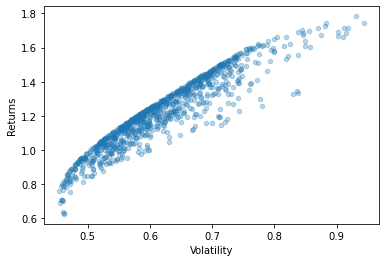

In [533]:
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
plt.show()

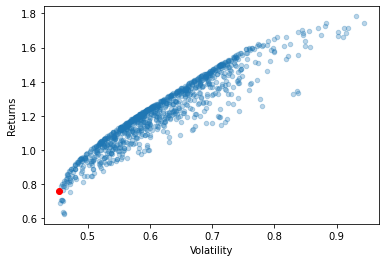

In [534]:
# 找到标准差最小数据的索引值
min_index = RandomPortfolios.Volatility.idxmin()

# 在收益-风险散点图中突出风险最小的点
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[min_index,'Volatility']
y = RandomPortfolios.loc[min_index,'Returns']
plt.scatter(x, y, color='red')   
plt.show()

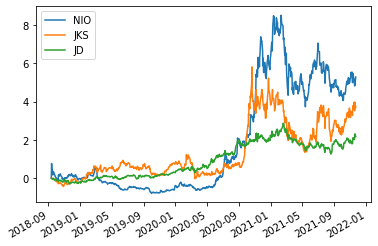

In [540]:
# 提取最小波动组合对应的权重, 并转换成Numpy数组
numstocks=3
GMV_weights = np.array(RandomPortfolios.iloc[min_index, 0:numstocks])

# 计算GMV投资组合收益
StockReturns['Portfolio_GMV'] = stock_return.mul(GMV_weights, axis=1).sum(axis=1)

# 绘制累积收益曲线
cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MCap', 'Portfolio_GMV'])

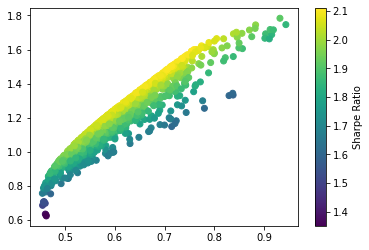

In [541]:
# 设置无风险回报率为0
risk_free = 0

# 计算每项资产的夏普比率
RandomPortfolios['Sharpe'] = (RandomPortfolios.Returns - risk_free)   \
                            / RandomPortfolios.Volatility

# 绘制收益-标准差的散点图，并用颜色描绘夏普比率
plt.scatter(RandomPortfolios.Volatility, RandomPortfolios.Returns, 
            c=RandomPortfolios.Sharpe)
plt.colorbar(label='Sharpe Ratio')
plt.show()

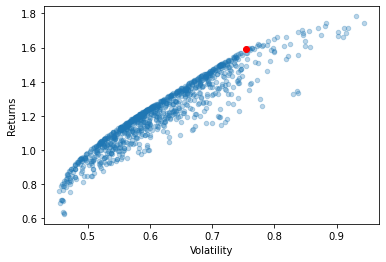

In [542]:
# 找到夏普比率最大数据对应的索引值
max_index = RandomPortfolios.Sharpe.idxmax()

# 在收益-风险散点图中突出夏普比率最大的点
RandomPortfolios.plot('Volatility', 'Returns', kind='scatter', alpha=0.3)
x = RandomPortfolios.loc[max_index,'Volatility']
y = RandomPortfolios.loc[max_index,'Returns']
plt.scatter(x, y, color='red')   
plt.show()

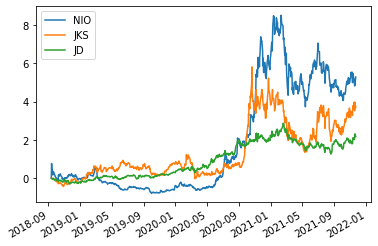

In [543]:
# 提取最大夏普比率组合对应的权重，并转化为numpy数组
MSR_weights = np.array(RandomPortfolios.iloc[max_index, 0:numstocks])

# 计算MSR组合的收益
StockReturns['Portfolio_MSR'] = stock_return.mul(MSR_weights, axis=1).sum(axis=1)

# 绘制累积收益曲线
cumulative_returns_plot(['Portfolio_EW', 'Portfolio_MCap',   \
                         'Portfolio_GMV', 'Portfolio_MSR'])

In [201]:
# Main function
def main():
    try:
        userUse=welcome()
        getTicker()
        
    except:
        return 'Please re-run the bot.'
    else:
        return 'See you!'
    
def portAssump():
    a=portfolioManage()
    a.portfolioWeight(a.marketCap(checkList))

In [202]:
main()

Dear user, welcome to Auto Stock Checker Bot.          First of all I'd like to have your name.wanye
Welcome to ASCB wanye .
Please let me know what stock information you want to know.MLT
1
             High    Low   Open  Close  Volume  Adj Close
Date                                                     
2017-03-13  9.993  9.855  9.977  9.882     0.0      9.882


'See you!'